# Assignment 2:

TensorFlow’s Decision Forest
(TF-DF) library to train, test and interpret Random Forests and Gradient Boosted Treesin TensorFlow running
over the Google colab, Hand-coded ID-3 decision tree classifier.

The overall goal in this assignment is to build a classification model (under Supervised learning) that predicts
whether a patient will experience in-hospital mortality using various features from the MIMIC dataset, such
as heart rate (HR), respiratory rate (RESP), oxygen saturation (SpO2), blood pressure (Systolic), blood pressure
(diastolic), and pulse rate (PULSE). You are given with data of two patients in the attached assignment
document (MIMIC dataset). The target variable (class) is a binary variable (Anomaly) defining in-hospital
mortality. That is ‘1’ indicates that the patient died during the hospital stay, and ‘0’ indicates that the patient
was discharged alive from the hospital.



'!' lets you to run commands in Google Collab cell environment

In [75]:
!pip install tensorflow_decision_forests

Import OS environment variables and other supporting libraries like Pandas, NumPy, TensorFlow and
TensorFlow-decision-forests.

In [76]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
import tensorflow_decision_forests as tfdf
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss
import matplotlib.pyplot as plt

Import datasets

In [77]:
p1 = pd.read_csv('221.csv')
p2 = pd.read_csv('230.csv')
p1

,RESP,BP-S,BP-D,SpO2,HR,PULSE,Anomaly
0,28,81,120,98,74,73,0
1,29,81,120,98,74,73,0
2,30,81,120,98,74,73,0
3,30,81,120,99,74,73,0
4,29,81,120,99,73,73,0
...,...,...,...,...,...,...,...
24994,27,79,113,99,92,93,0
24995,27,79,115,99,92,93,0
24996,27,80,116,99,93,93,0
24997,27,80,115,100,93,96,0


In [78]:
p2

,RESP,BP-S,BP-D,SpO2,HR,PULSE,Anomaly
0,15,54,73,97,72,71,0
1,15,54,73,97,72,71,0
2,15,54,73,97,72,71,0
3,15,54,73,97,72,71,0
4,15,55,74,97,72,71,0
...,...,...,...,...,...,...,...
24995,19,63,86,93,88,88,0
24996,19,64,86,93,88,88,0
24997,19,64,87,93,88,88,0
24998,19,64,87,93,88,88,0


Data exploration and preprocessing.

1. Dropping duplicate records

In [79]:
duplicates_patient1 = p1.duplicated().sum()
duplicates_patient2 = p2.duplicated().sum()

print(f"Patient 1 duplicates: {duplicates_patient1}")
print(f"Patient 2 duplicates: {duplicates_patient2}")

p1 = p1.drop_duplicates()
p2 = p2.drop_duplicates()

Patient 1 duplicates: 9445
Patient 2 duplicates: 16551


2. Checking for Null values

In [80]:
p1.isnull().sum()

,0
RESP,0
BP-S,0
BP-D,0
SpO2,0
HR,0
PULSE,0
Anomaly,0


In [81]:
p2.isnull().sum()

,0
RESP,0
BP-S,0
BP-D,0
SpO2,0
HR,0
PULSE,0
Anomaly,0


There are no null values so, no imputation required.

3. No need for Normalizing/Standardizing data for decision tree based algorithms because :
    
    i) Non-linear nature of decision trees

    ii) Splitting logic is independent of feature scaling

    iii) No distance based calculations




ID3 for Patient-1 dataset using scikit-learn library

In [82]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

X_p1 = p1.drop(columns=['Anomaly'])
y_p1 = p1['Anomaly']

X_train_p1, X_test_p1, y_train_p1, y_test_p1 = train_test_split(X_p1, y_p1, test_size=0.3, random_state=42)

id3_model = DecisionTreeClassifier(criterion='entropy')
id3_model.fit(X_train_p1, y_train_p1)

accuracy_id3 = id3_model.score(X_test_p1, y_test_p1)
print(f"ID3 Model Accuracy on Patient-1 dataset using scikit-learn: {accuracy_id3*100:.2f}%")

ID3 Model Accuracy on Patient-1 dataset using scikit-learn: 98.93%


ID3 for Patient-1 dataset - Custom Implementation

In [83]:
def entropy(y):
    unique_classes, counts = np.unique(y, return_counts=True)
    probabilities = counts / len(y)
    return -np.sum(probabilities * np.log2(probabilities))

def information_gain(X, y, feature):
    total_entropy = entropy(y)
    values, counts = np.unique(X[feature], return_counts=True)

    weighted_entropy = np.sum((counts[i] / np.sum(counts)) * entropy(y[X[feature] == values[i]]) for i in range(len(values)))

    return total_entropy - weighted_entropy

def best_feature_to_split(X, y):
    if X.empty:
        return None

    best_gain = 0
    best_feature = None
    for feature in X.columns:
        gain = information_gain(X, y, feature)
        if gain > best_gain:
            best_gain = gain
            best_feature = feature
    return best_feature

def stopping_condition(y):
    if len(np.unique(y)) == 1:
        return True
    return False

def id3_tree(X, y):
    if stopping_condition(y):
        return np.unique(y)[0]

    best_feature = best_feature_to_split(X, y)
    if best_feature is None:
        return np.unique(y)[0]

    tree = {best_feature: {}}

    for value in np.unique(X[best_feature]):
        sub_X = X[X[best_feature] == value].drop(columns=[best_feature])
        sub_y = y[X[best_feature] == value]

        subtree = id3_tree(sub_X, sub_y)
        tree[best_feature][value] = subtree

    return tree

def predict_example(example, tree):
    if not isinstance(tree, dict):
        return tree

    feature = list(tree.keys())[0]
    value = example[feature]
    if value in tree[feature]:
        return predict_example(example, tree[feature][value])
    else:
        return 0

tree = id3_tree(X_train_p1, y_train_p1)


predictions = X_test_p1.apply(predict_example, axis=1, args=(tree,))



<ipython-input-83-4f372b42deb4>:10: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  weighted_entropy = np.sum((counts[i] / np.sum(counts)) * entropy(y[X[feature] == values[i]]) for i in range(len(values)))
<ipython-input-83-4f372b42deb4>:10: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  weighted_entropy = np.sum((counts[i] / np.sum(counts)) * entropy(y[X[feature] == values[i]]) for i in range(len(values)))
<ipython-input-83-4f372b42deb4>:10: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  weighted_entropy = np.sum((counts[i] / np.sum(counts)) * entropy(y[X[feature] == values[i]]) for i in ran

In [84]:
accuracy = accuracy_score(y_test_p1, predictions)
print(f'ID3 Model Accuracy on Patient-1 dataset - Custom implementation is: {accuracy * 100:.2f}%')

ID3 Model Accuracy on Patient-1 dataset - Custom implementation is: 97.71%


Observation : custom ID3 implementation resulted in lower accuracy because it lacks the optimizations present in Scikit-learn's DecisionTreeClassifier, such as handling unseen values, pruning to avoid overfitting, and efficient stopping criteria.

In [85]:
train_dataset_p1 = tfdf.keras.pd_dataframe_to_tf_dataset(p1, label="Anomaly")

random_forest_model = tfdf.keras.RandomForestModel()
random_forest_model.fit(train_dataset_p1)

tfdf.model_plotter.plot_model_in_colab(random_forest_model, tree_idx=0, max_depth=3)


Use /tmp/tmpdyqpi5l_ as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.620728. Found 15554 examples.
Training model...
Model trained in 0:00:06.573672
Compiling model...
Model compiled.


CART Implementation on Patient-2 dataset utilizing Scikit-Learn's DecisionTreeClassifier:

In [86]:
X_p2 = p2.drop(columns=['Anomaly'])
y_p2 = p2['Anomaly']

X_train_p2, X_test_p2, y_train_p2, y_test_p2 = train_test_split(X_p2, y_p2, test_size=0.3, random_state=42)

cart_model = DecisionTreeClassifier(criterion='gini')
cart_model.fit(X_train_p2, y_train_p2)

accuracy_cart = cart_model.score(X_test_p2, y_test_p2)
print(f"CART Model Accuracy on Patient-2 dataset utilizing Scikit-Learn's DecisionTreeClassifier: {accuracy_cart*100:.2f}")

CART Model Accuracy on Patient-2 dataset utilizing Scikit-Learn's DecisionTreeClassifier: 98.66


CART Implementation utilizing Tensorflow's CartModel:

In [87]:
train_dataset_p2 = tfdf.keras.pd_dataframe_to_tf_dataset(p2, label="Anomaly")

cart_model_tf = tfdf.keras.CartModel()
cart_model_tf.fit(train_dataset_p2)

evaluation = cart_model_tf.evaluate(train_dataset_p2)
print(f"Accuracy on Patient-2 dataset utilizing Tensorflow's CartModel: {evaluation}")

Use /tmp/tmpiymf_yzp as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.002137. Found 8449 examples.
Training model...
Model trained in 0:00:00.132248
Compiling model...
Model compiled.
9/9 [==============================] - 1s 21ms/step - loss: 0.0000e+00
Accuracy on Patient-2 dataset utilizing Tensorflow's CartModel: 0.0


Scikit-learn's DecisionTreeClassifier implements CART (Classification and Regression Trees) using the Gini impurity or entropy for classification, and handles categorical features efficiently. TensorFlow's CartModel focuses more on scalability and is often integrated with TensorFlow's ecosystem, offering more flexibility for large-scale distributed training.

**ID3 Strengths:**
- Simple and intuitive algorithm based on information gain (entropy).
- Works well for categorical features.

**ID3 Weaknesses:**
- Prone to overfitting without pruning.
- Cannot handle numeric features directly without preprocessing.

**CART Strengths:**
- Handles both categorical and numerical features.
- Supports pruning, reducing overfitting.

**CART Weaknesses:**
- Slower with large datasets.
- Splits based on Gini impurity or variance may not always capture best splits for complex data.


Visualizing the Hypothesis space by producing the scatter plot of the dataset (MIMIC dataset given).

1. Pairwise plots for features in Patient-1 dataset

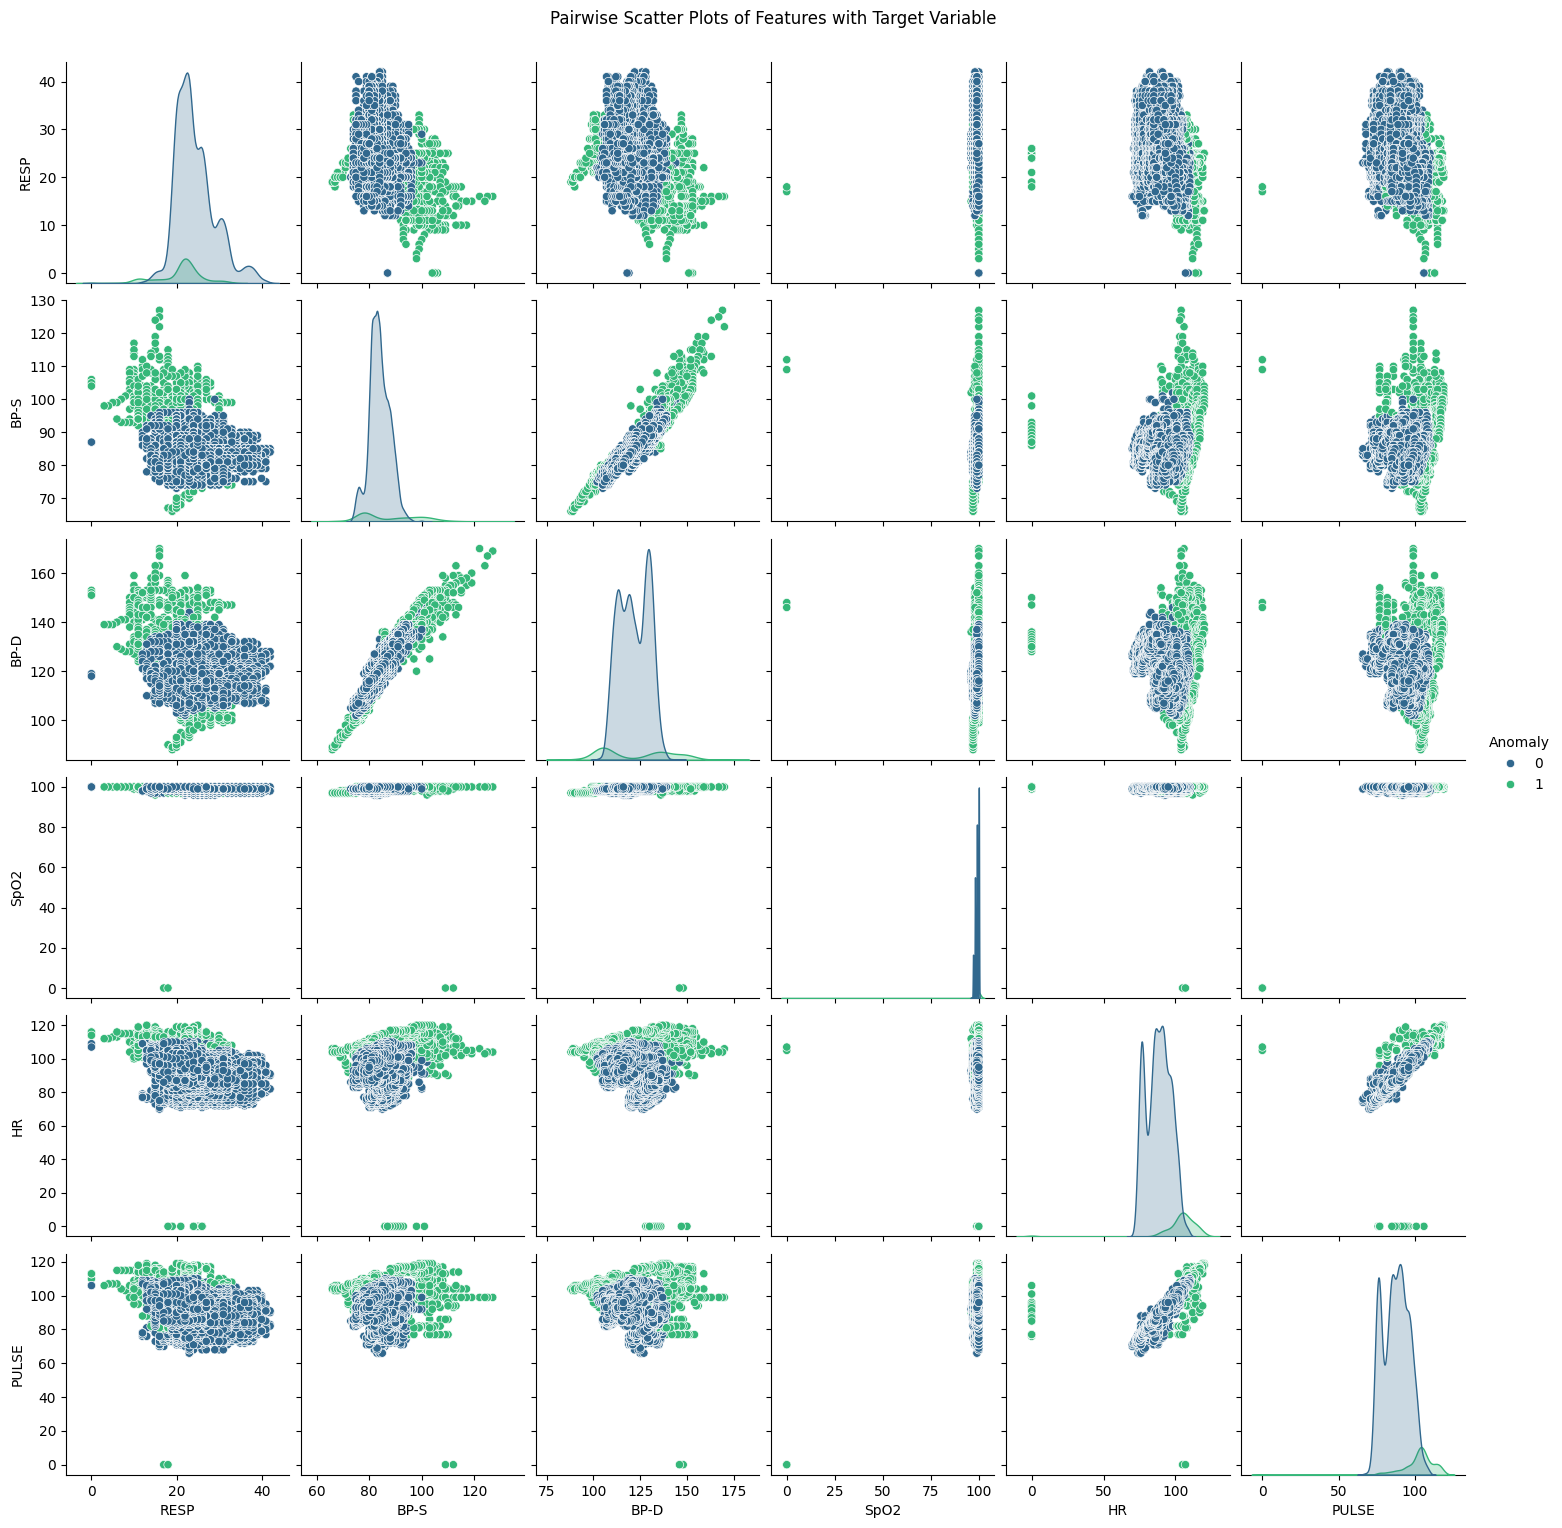

In [88]:
sns.pairplot(p1,hue='Anomaly',palette='viridis')
plt.suptitle('Pairwise Scatter Plots of Features with Target Variable', y=1.02)
plt.show()

2. Pairwise plots for features in Patient-2 dataset

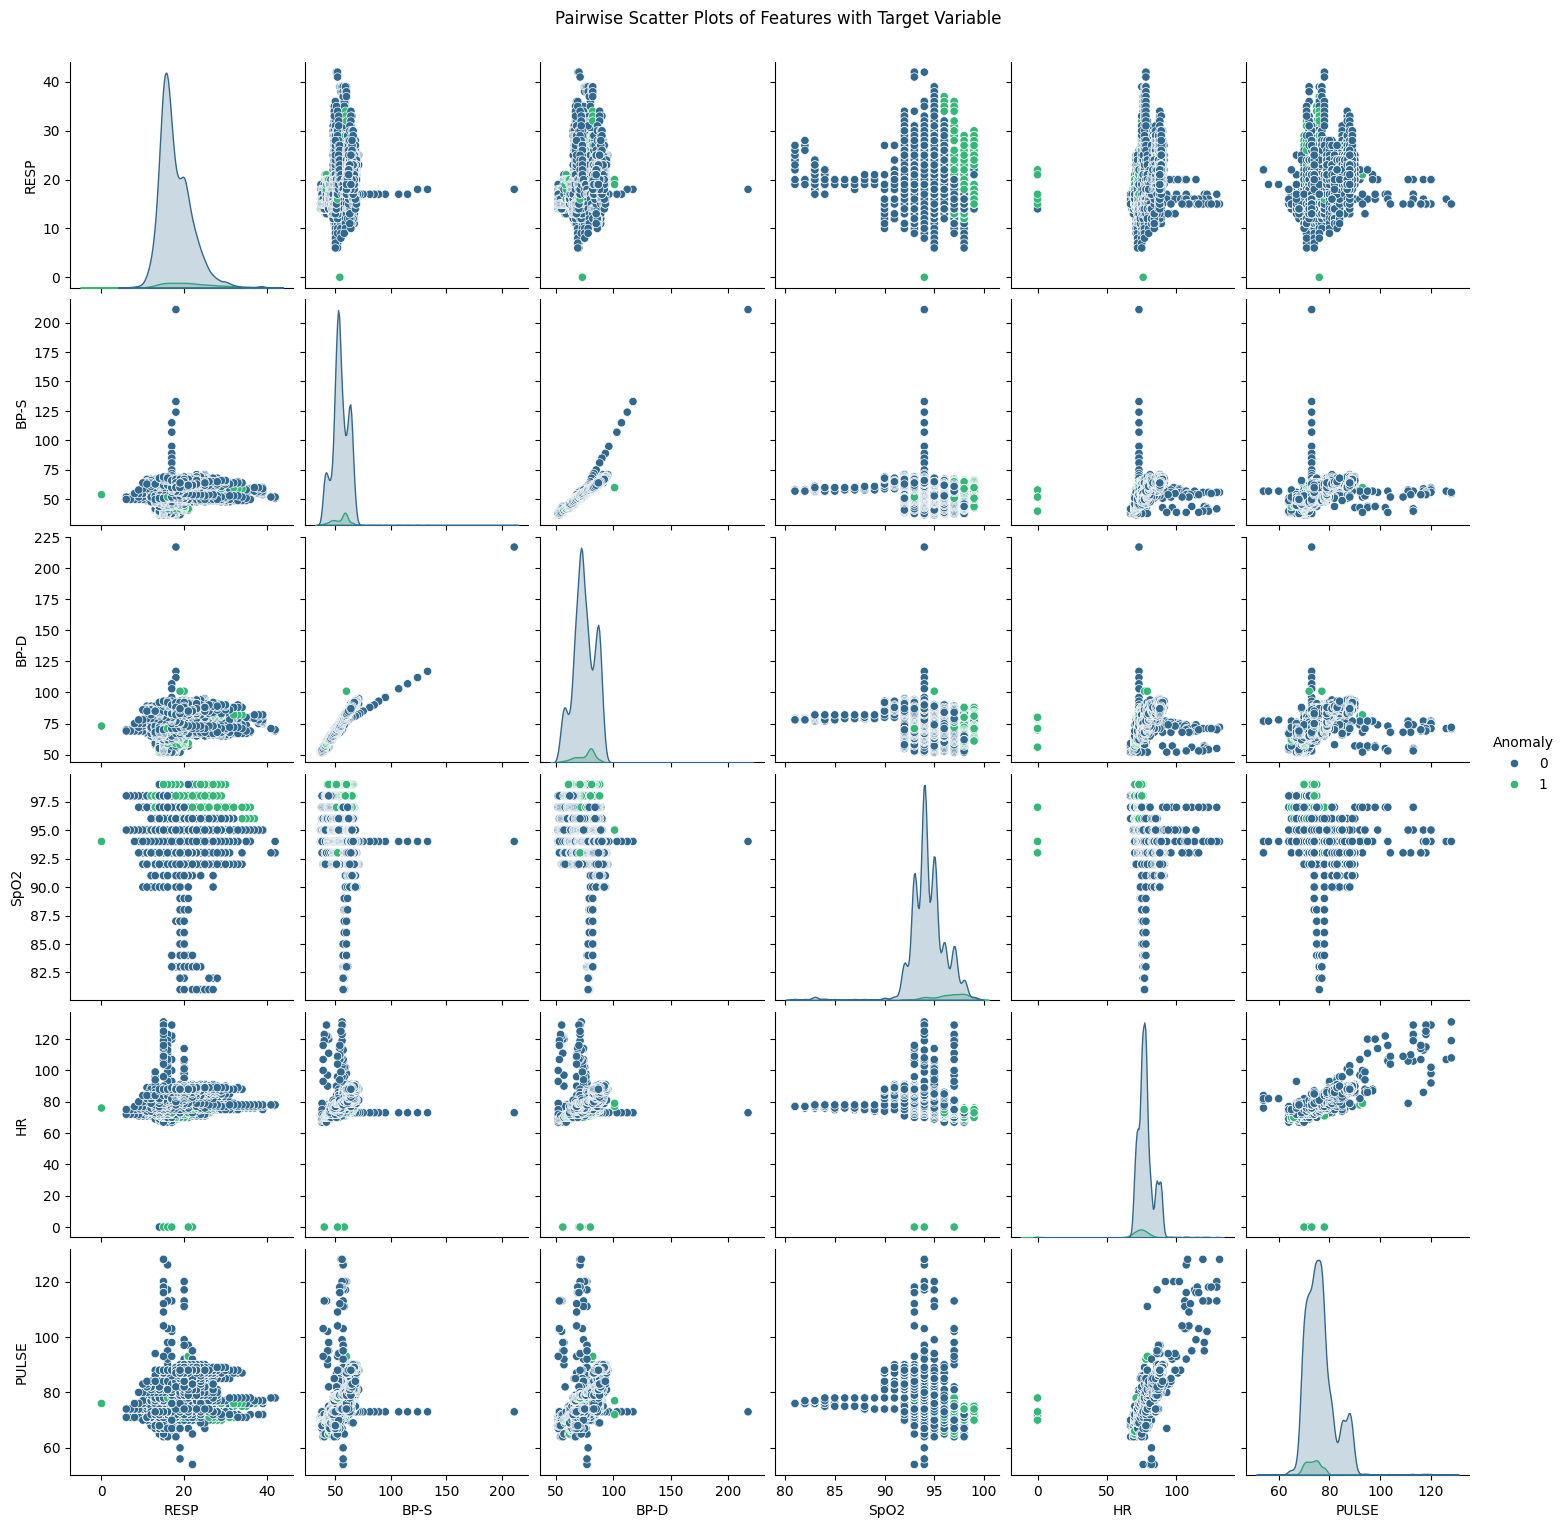

In [89]:
sns.pairplot(p2,hue='Anomaly',palette='viridis')
plt.suptitle('Pairwise Scatter Plots of Features with Target Variable', y=1.02)
plt.show()

Implement Gradient Boosted Decision Trees (GBDT) with various hyper-parameters on Patient-2
dataset. Compare the accuracy and log loss of these GBDT models to the Random Forest. Analyze the
results and draw insights into the differences between the two approaches. Consider factors such as
overfitting, underfitting, and the impact of hyper-parameter tuning on model performance.

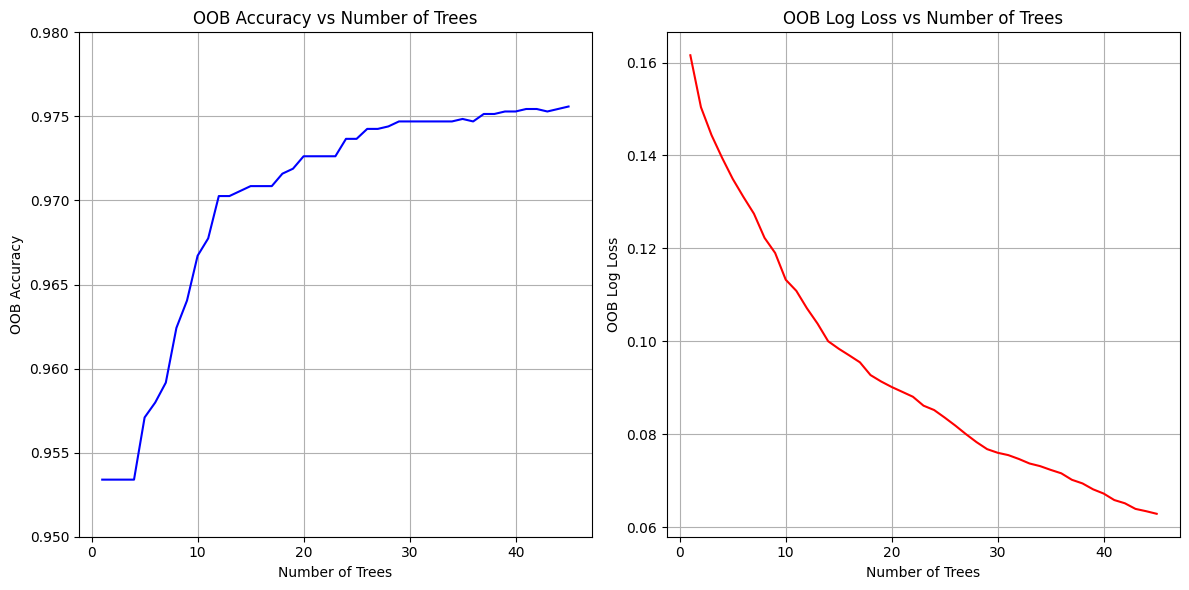

In [90]:
from sklearn.ensemble import GradientBoostingClassifier
data = p2

X = data.drop(columns=['Anomaly'])
y = data['Anomaly']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

n_estimators = 45
gbdt_model = GradientBoostingClassifier(n_estimators=n_estimators, learning_rate=0.1, max_depth=3)

gbdt_model.fit(X_train, y_train)

oob_accuracy = []
oob_log_loss = []

for y_pred_proba in gbdt_model.staged_predict_proba(X_train):
    y_pred = np.argmax(y_pred_proba, axis=1)
    accuracy = accuracy_score(y_train, y_pred)
    logloss = log_loss(y_train, y_pred_proba)

    oob_accuracy.append(accuracy)
    oob_log_loss.append(logloss)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(np.arange(1, n_estimators + 1), oob_accuracy, label='OOB Accuracy', color='blue')
plt.ylim(0.950, 0.980)
plt.title('OOB Accuracy vs Number of Trees')
plt.xlabel('Number of Trees')
plt.ylabel('OOB Accuracy')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(np.arange(1, n_estimators + 1), oob_log_loss, label='OOB Log Loss', color='red')
plt.title('OOB Log Loss vs Number of Trees')
plt.xlabel('Number of Trees')
plt.ylabel('OOB Log Loss')
plt.grid(True)

plt.tight_layout()
plt.show()

In [91]:
gbdt_model = tfdf.keras.GradientBoostedTreesModel()
gbdt_model.fit(train_dataset_p2)

inspector=gbdt_model.make_inspector()
feature_imp=inspector.variable_importances()
feature_imp



Use /tmp/tmpzya0kcmo as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.389458. Found 8449 examples.
Training model...
Model trained in 0:00:01.507804
Compiling model...
Model compiled.


{'INV_MEAN_MIN_DEPTH': [("HR" (1; #2), 0.37918573962563157),
  ("SpO2" (1; #5), 0.27496378485785905),
  ("BP-D" (1; #0), 0.27446386390077326),
  ("RESP" (1; #4), 0.26157370447805595),
  ("BP-S" (1; #1), 0.23158187655164375),
  ("PULSE" (1; #3), 0.22600937837378746)],
 'NUM_NODES': [("BP-D" (1; #0), 921.0),
  ("RESP" (1; #4), 899.0),
  ("HR" (1; #2), 750.0),
  ("SpO2" (1; #5), 689.0),
  ("BP-S" (1; #1), 667.0),
  ("PULSE" (1; #3), 643.0)],
 'NUM_AS_ROOT': [("HR" (1; #2), 123.0),
  ("SpO2" (1; #5), 52.0),
  ("BP-D" (1; #0), 27.0),
  ("RESP" (1; #4), 17.0),
  ("BP-S" (1; #1), 16.0),
  ("PULSE" (1; #3), 11.0)],
 'SUM_SCORE': [("HR" (1; #2), 239.412228240477),
  ("BP-D" (1; #0), 229.6390216867611),
  ("SpO2" (1; #5), 220.86595471529978),
  ("BP-S" (1; #1), 176.89290823338087),
  ("RESP" (1; #4), 175.3026227289538),
  ("PULSE" (1; #3), 132.22993532868037)]}

In [92]:
inspector=cart_model_tf.make_inspector()
feature_imp=inspector.variable_importances()
feature_imp

{'INV_MEAN_MIN_DEPTH': [("SpO2" (1; #5), 1.0),
  ("RESP" (1; #4), 0.36363636363636365),
  ("HR" (1; #2), 0.22727272727272727),
  ("BP-S" (1; #1), 0.1869158878504673),
  ("BP-D" (1; #0), 0.18099547511312217),
  ("PULSE" (1; #3), 0.136986301369863)],
 'SUM_SCORE': [("SpO2" (1; #5), 330.72368160262704),
  ("HR" (1; #2), 215.64891235530376),
  ("BP-D" (1; #0), 172.80538587551564),
  ("RESP" (1; #4), 160.73250642511994),
  ("BP-S" (1; #1), 100.6672180891037),
  ("PULSE" (1; #3), 51.30827707052231)],
 'NUM_NODES': [("RESP" (1; #4), 11.0),
  ("BP-D" (1; #0), 8.0),
  ("BP-S" (1; #1), 6.0),
  ("HR" (1; #2), 5.0),
  ("PULSE" (1; #3), 5.0),
  ("SpO2" (1; #5), 4.0)],
 'NUM_AS_ROOT': [("SpO2" (1; #5), 1.0)]}